In [2]:
# Provides a way of using operating system dependent functionality. 
import os

# LibROSA provides the audio analysis
import librosa
# Need to implictly import from librosa
import librosa.display

# Import the audio playback widget
import IPython.display as ipd
from IPython.display import Image

# Enable plot in the notebook
import matplotlib.pyplot as plt

# These are generally useful to have around
import numpy as np
import pandas as pd


# To build Neural Network and Create desired Model
import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D #, AveragePooling1D
from keras.layers import Flatten, Dropout, Activation # Input, 
from keras.layers import Dense #, Embedding
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

Data Preparation


Plotting the audio file's waveform and its spectrogram


In [3]:
data, sampling_rate = librosa.load("C:\\Users\\Dhairya Hindoriya\\OneDrive\\Desktop\\SER\\Dataset\\happy\\happy013.wav")
# To play audio this in the jupyter notebook
ipd.Audio("C:\\Users\\Dhairya Hindoriya\\OneDrive\\Desktop\\SER\\Dataset\\happy\\happy013.wav")

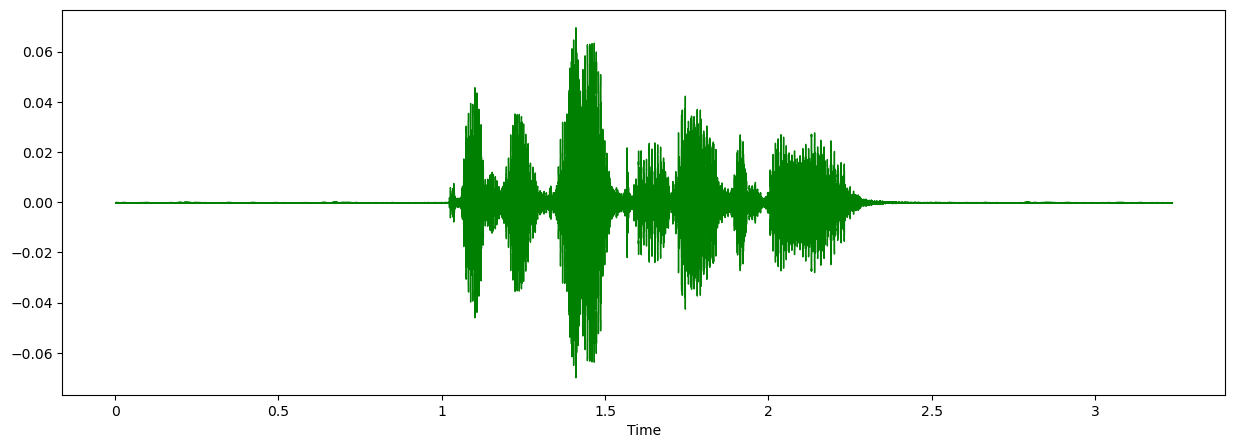

In [4]:
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate, color="green")
plt.show()

Setup the Basic Paramter

In [5]:
dataset_path = os.path.abspath('C:\\Users\\Dhairya Hindoriya\\OneDrive\\Desktop\\SER\\Dataset')
destination_path = os.path.abspath('./')
# To shuffle the dataset instances/records
randomize = True
# for spliting dataset into training and testing dataset
split = 0.8
# Number of sample per second e.g. 16KHz
sampling_rate = 20000 
emotions=["anger","disgust","fear","happy","neutral", "sad", "surprise"]

Converting Dataset in CSV format

In [6]:
# loading dataframes using dataset module 
from dataset import create_and_load_meta_csv_df
df, train_df, test_df =create_and_load_meta_csv_df(dataset_path, destination_path, randomize, split)

In [7]:
print('Dataset samples  : ', len(df),"\nTraining Samples : ", len(train_df),"\ntesting Samples  : ", len(test_df))

Dataset samples  :  2556 
Training Samples :  2044 
testing Samples  :  512


Data Visualization

In [8]:
df.head()

,path,label
0,C:\Users\Dhairya Hindoriya\OneDrive\Desktop\SE...,3
1,C:\Users\Dhairya Hindoriya\OneDrive\Desktop\SE...,4
2,C:\Users\Dhairya Hindoriya\OneDrive\Desktop\SE...,5
3,C:\Users\Dhairya Hindoriya\OneDrive\Desktop\SE...,0
4,C:\Users\Dhairya Hindoriya\OneDrive\Desktop\SE...,3


In [9]:
print("Actual Audio : ", df['path'][0])
print("Labels       : ", df['label'][0])

Actual Audio :  C:\Users\Dhairya Hindoriya\OneDrive\Desktop\SER\Dataset\happy\happy143.wav
Labels       :  3


Labels Assigned for emotions :
0 : anger
1 : disgust
2 : fear
3 : happy
4 : neutral
5 : sad
6 : surprise

In [10]:
unique_labels = train_df.label.unique()
unique_labels.sort()
print("unique labels in Emtion dataset : ")
print(*unique_labels, sep=', ')
unique_labels_counts = train_df.label.value_counts(sort=False)
print("\n\nCount of unique labels in Emtion dataset : ")
print(*unique_labels_counts,sep=', ')

unique labels in Emtion dataset : 
0, 1, 2, 3, 4, 5, 6


Count of unique labels in Emtion dataset : 
346, 240, 353, 363, 201, 195, 346


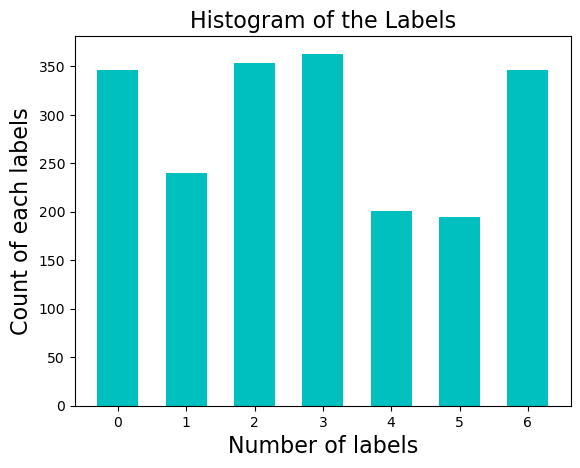

In [11]:
# Histogram of the classes
plt.bar(unique_labels, unique_labels_counts,align = 'center', width=0.6, color = 'c')
plt.xlabel('Number of labels', fontsize=16)
plt.xticks(unique_labels)
plt.ylabel('Count of each labels', fontsize=16)
plt.title('Histogram of the Labels', fontsize=16)
plt.show()

Data Pre-Processing

Getting the features of audio files using librosa
Calculating MFCC, Pitch, magnitude, Chroma features.



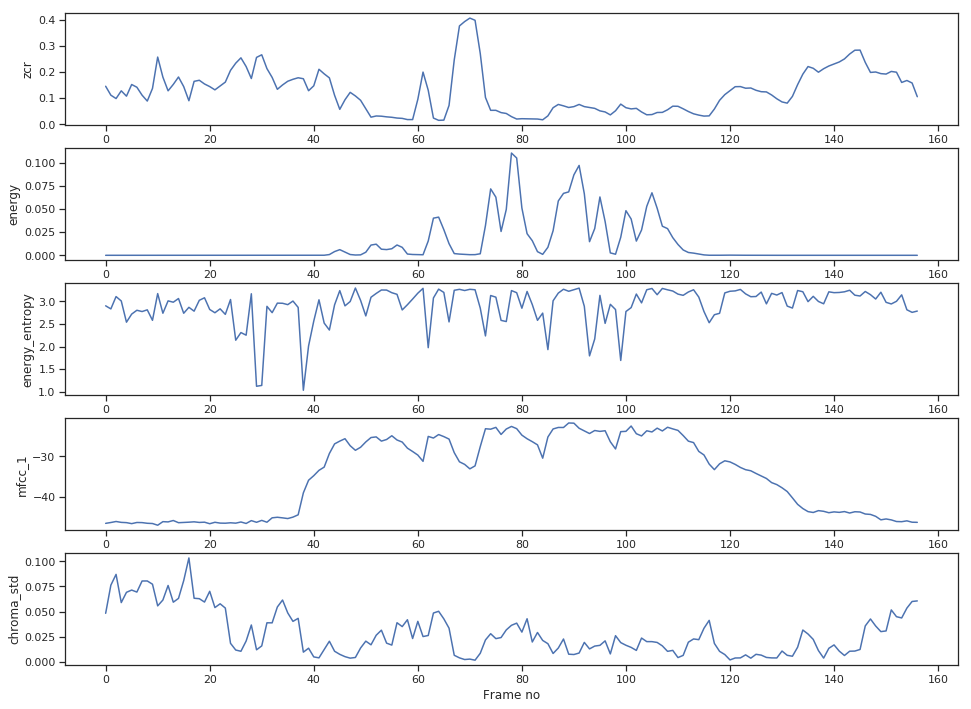

In [12]:
Image('C:\\Users\\Dhairya Hindoriya\\OneDrive\\Desktop\\SER\\images\\feature_plots.png')

In [13]:
from feature_extraction import get_features_dataframe
from feature_extraction import get_audio_features

In [14]:
trainfeatures = pd.read_pickle('C:\\Users\\Dhairya Hindoriya\\OneDrive\\Desktop\\SER\\features_dataframe\\trainfeatures')
trainlabel = pd.read_pickle('C:\\Users\\Dhairya Hindoriya\\OneDrive\\Desktop\\SER\\features_dataframe\\trainlabel')
testfeatures = pd.read_pickle("C:\\Users\\Dhairya Hindoriya\\OneDrive\\Desktop\SER\\features_dataframe\\testfeatures")
testlabel = pd.read_pickle('C:\\Users\\Dhairya Hindoriya\\OneDrive\\Desktop\SER\\features_dataframe\\testlabel')

In [15]:
trainfeatures.shape

(2044, 65)

In [16]:
trainfeatures = trainfeatures.fillna(0)
testfeatures = testfeatures.fillna(0)

In [17]:
# By using .ravel() : Converting 2D to 1D e.g. (512,1) -> (512,). To prevent DataConversionWarning

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel).ravel()
X_test = np.array(testfeatures)
y_test = np.array(testlabel).ravel()

In [18]:
y_train[:5]

array([3, 2, 2, 0, 3], dtype=int64)

In [19]:
# One-Hot Encoding
lb = LabelEncoder()

y_train =to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

In [20]:
y_train[:5]

array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

Changing dimension for CNN model

In [21]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [22]:
x_traincnn.shape

(2044, 65, 1)

Model Creation

In [23]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',input_shape=(x_traincnn.shape[1],x_traincnn.shape[2])))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(y_train.shape[1]))
model.add(Activation('softmax'))
#opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 65, 256)           1536      
                                                                 
 activation (Activation)     (None, 65, 256)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 65, 128)           163968    
                                                                 
 activation_1 (Activation)   (None, 65, 128)           0         
                                                                 
 dropout (Dropout)           (None, 65, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 8, 128)            0         
 D)                                                              
                                                        

In [25]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'])


Training and Evaluation

In [26]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=400, validation_data=(x_testcnn, y_test))

Epoch 1/400


128/128 [==============================] - 7s 24ms/step - loss: 2.5154 - accuracy: 0.1981 - val_loss: 1.9718 - val_accuracy: 0.1875
Epoch 2/400
128/128 [==============================] - 2s 16ms/step - loss: 1.6915 - accuracy: 0.3185 - val_loss: 1.6041 - val_accuracy: 0.3594
Epoch 3/400
128/128 [==============================] - 2s 18ms/step - loss: 1.5390 - accuracy: 0.3909 - val_loss: 1.4961 - val_accuracy: 0.4062
Epoch 4/400
128/128 [==============================] - 2s 18ms/step - loss: 1.4165 - accuracy: 0.4344 - val_loss: 1.5292 - val_accuracy: 0.3535
Epoch 5/400
128/128 [==============================] - 3s 21ms/step - loss: 1.3736 - accuracy: 0.4550 - val_loss: 1.4482 - val_accuracy: 0.4375
Epoch 6/400
128/128 [==============================] - 3s 20ms/step - loss: 1.3202 - accuracy: 0.4848 - val_loss: 1.3405 - val_accuracy: 0.4453
Epoch 7/400
128/128 [==============================] - 3s 24ms/step - loss: 1.2652 - accuracy: 0.4956 - val_loss: 1.3991 - val_accurac

Loss Vs Iterations

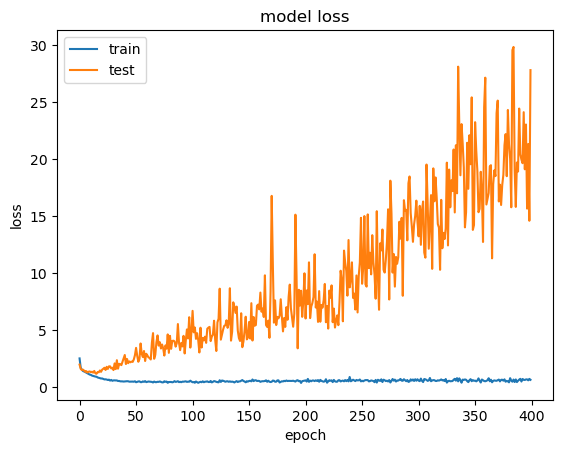

In [27]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Saving the model

In [28]:
model_name = 'Speech_Emotion_Recognition_Model.h5'
save_dir = os.path.join(os.getcwd(), 'Trained_Models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

c:\Users\Dhairya Hindoriya\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved trained model at c:\Users\Dhairya Hindoriya\OneDrive\Desktop\SER\utils\Trained_Models\Speech_Emotion_Recognition_Model.h5 


In [29]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

Loading the model

In [30]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./Trained_Models/Speech_Emotion_Recognition_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy',metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 55.66%


Test Set Prediction


Predicting emotions on the test data

In [31]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

16/16 [==============================] - 5s 9ms/step


In [32]:
preds


array([[9.9999988e-01, 1.0847962e-19, 4.5319890e-09, ..., 1.3559840e-07,
        2.4697105e-10, 3.9415748e-11],
       [1.4260468e-02, 0.0000000e+00, 9.8573953e-01, ..., 0.0000000e+00,
        5.7052416e-31, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 9.0360609e-34, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 6.1492437e-32, 8.2996610e-38, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [9.9976414e-01, 2.5826596e-06, 4.1185436e-26, ..., 0.0000000e+00,
        0.0000000e+00, 2.3322261e-04]], dtype=float32)

In [33]:
preds1=preds.argmax(axis=1)

In [34]:
preds1

array([0, 2, 1, 3, 3, 6, 6, 2, 3, 2, 2, 1, 0, 4, 4, 3, 0, 6, 5, 5, 2, 1,
       3, 4, 0, 3, 6, 2, 5, 3, 3, 4, 2, 3, 1, 3, 5, 3, 2, 3, 6, 6, 4, 0,
       5, 0, 1, 1, 3, 5, 1, 3, 3, 5, 4, 5, 2, 2, 5, 4, 3, 3, 5, 0, 0, 3,
       5, 2, 0, 2, 3, 0, 3, 3, 4, 2, 5, 6, 0, 0, 5, 0, 0, 0, 3, 3, 6, 0,
       2, 0, 3, 2, 4, 2, 6, 3, 4, 1, 1, 5, 0, 3, 3, 5, 3, 5, 5, 1, 3, 0,
       0, 0, 0, 3, 4, 3, 0, 5, 5, 3, 5, 3, 3, 0, 0, 2, 2, 2, 5, 3, 1, 2,
       1, 3, 4, 0, 3, 0, 3, 4, 0, 0, 1, 2, 0, 0, 5, 2, 0, 2, 5, 3, 3, 2,
       5, 2, 1, 2, 6, 5, 2, 5, 5, 0, 0, 6, 4, 4, 3, 6, 6, 5, 6, 4, 3, 1,
       2, 3, 2, 5, 0, 0, 4, 5, 0, 2, 2, 5, 1, 3, 6, 3, 4, 0, 4, 1, 0, 6,
       5, 2, 0, 2, 5, 1, 3, 3, 4, 5, 0, 5, 3, 3, 6, 0, 1, 5, 4, 6, 5, 4,
       2, 3, 0, 3, 4, 4, 1, 5, 5, 3, 5, 4, 4, 5, 0, 0, 5, 5, 3, 6, 6, 4,
       5, 2, 3, 5, 5, 2, 1, 0, 2, 4, 0, 3, 2, 1, 3, 5, 3, 6, 3, 3, 4, 4,
       3, 2, 3, 2, 3, 2, 0, 4, 2, 5, 4, 3, 3, 3, 0, 0, 2, 4, 5, 0, 6, 5,
       3, 4, 5, 6, 5, 3, 0, 6, 5, 0, 0, 6, 5, 3, 2,

In [35]:
abc = preds1.astype(int).flatten()

In [36]:
predictions = (lb.inverse_transform((abc)))

In [37]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,0
1,2
2,1
3,3
4,3
5,6
6,6
7,2
8,3
9,2


In [38]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [39]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,2
1,0
2,1
3,2
4,3
5,6
6,6
7,5
8,3
9,5


In [40]:
finaldf = actualdf.join(preddf)

Actual v/s Predicted emotions

In [41]:
finaldf[170:180]

,actualvalues,predictedvalues
170,6,6
171,1,5
172,1,6
173,4,4
174,3,3
175,1,1
176,6,2
177,0,3
178,2,2
179,5,5


In [42]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
0,81
1,60
2,83
3,85
4,53
5,97
6,53


In [43]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
0,94
1,31
2,78
3,114
4,49
5,97
6,49


In [44]:
finaldf.to_csv('Predictions.csv', index=False)